### Cloud cover Segmentation

This jupyter notebook implements a cloud segmentation taks from satellite images. 
The data consists on 12 images, each  with a tile_id and  date will be the unique identifier. For each image, there is a corresponding cloud mask with the same identificator. The images have 11 channels/bands. For simplicity and to save space and memory the tiles are also available as RGB only 3-bands (500mb instead of 2.5GB tif files).

To make things easier (in terms of memory), the images_RGB will be used for the task of cloud segmentation. 

To segment clouds, I decided to use a ML approach, which is explained in this jupyter notebook. The main steps can be summarised as follows:

1. Before starting, I decided to use 11 images and masks for training and validation, and I left one image for testing purposes.  
2. As the original images are: 10980x10980 pixels, which is too large to train the model, the images and masks are divided into small patches. This steps is performed using "patchify", which split a large image into a number of patches with a selected size (i.e., 256x256).  
3. Once the patches are created, a proper dataset to train the model is created.
4. A simple implementation of the classic UNet is used for the image segmentation.


### Organization and technical aspects:

The main functions for processing the data and the model are in the *py files provided along this jupyter notebook.
The python packages used are in requiments.txt. 

The jupyter notebook has been run in a local machine (cpu), which is not ideal, as it consumes too much memory. 


In [1]:
# Uncomment this cell if using google colab 

In [2]:
#from google.colab import drive
#drive.mount('/gdrive/')
# Set the right path
#cd '/gdrive/MyDrive/CloudSegmentation/'
#!pip install -r '/gdrive/MyDrive/CloudSegmentation/requirements.txt'

### Import libraries

In [69]:
from matplotlib import pyplot as plt
import os
import rasterio
import numpy as np
import cv2
from patchify import patchify
import albumentations as A
from torch.utils.data import Dataset, DataLoader, sampler
from utils import *
from Unet import *

### Data exploration

In [2]:
# Open an image and the corresponding mask
file_img = 'images/train/Sentinel2L2A_sen2cor_21NYC_20171206_clouds=43.6%_area=100%.tif'
file_rgb_img = 'images_RGB//train/Sentinel2L2A_sen2cor_21NYC_20171206_clouds=43.6%_area=100%_RGB.tif'
file_mask = 'mask/train/cloud_mask_21NYC_20171206_clouds=84%.tif'

In [3]:
# No bands specified
img, metadata = read_crop(file_img, None, None)
img_rgb, metadata = read_crop(file_rgb_img, None, None)
mask, metadata = read_crop(file_mask, None, None)

In [4]:
metadata

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32621),
 'transform': Affine(10.0, 0.0, 699960.0,
        0.0, -10.0, 300000.0)}

In [5]:
print(mask.shape)
print(img.shape)
print(img_rgb.shape) 

(1, 10980, 10980)
(11, 10980, 10980)
(3, 10980, 10980)


In [6]:
# Visualise all bands

In [7]:
def show_images(images, cols = 1):

    n_images = len(images)
    titles = ['Band %d' % i for i in range(1,n_images + 1)]
    plt.figure(figsize=(20,10))
    
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(int(len(images) / cols + 1), cols, i + 1)
        plt.imshow(image)
        plt.title(title)

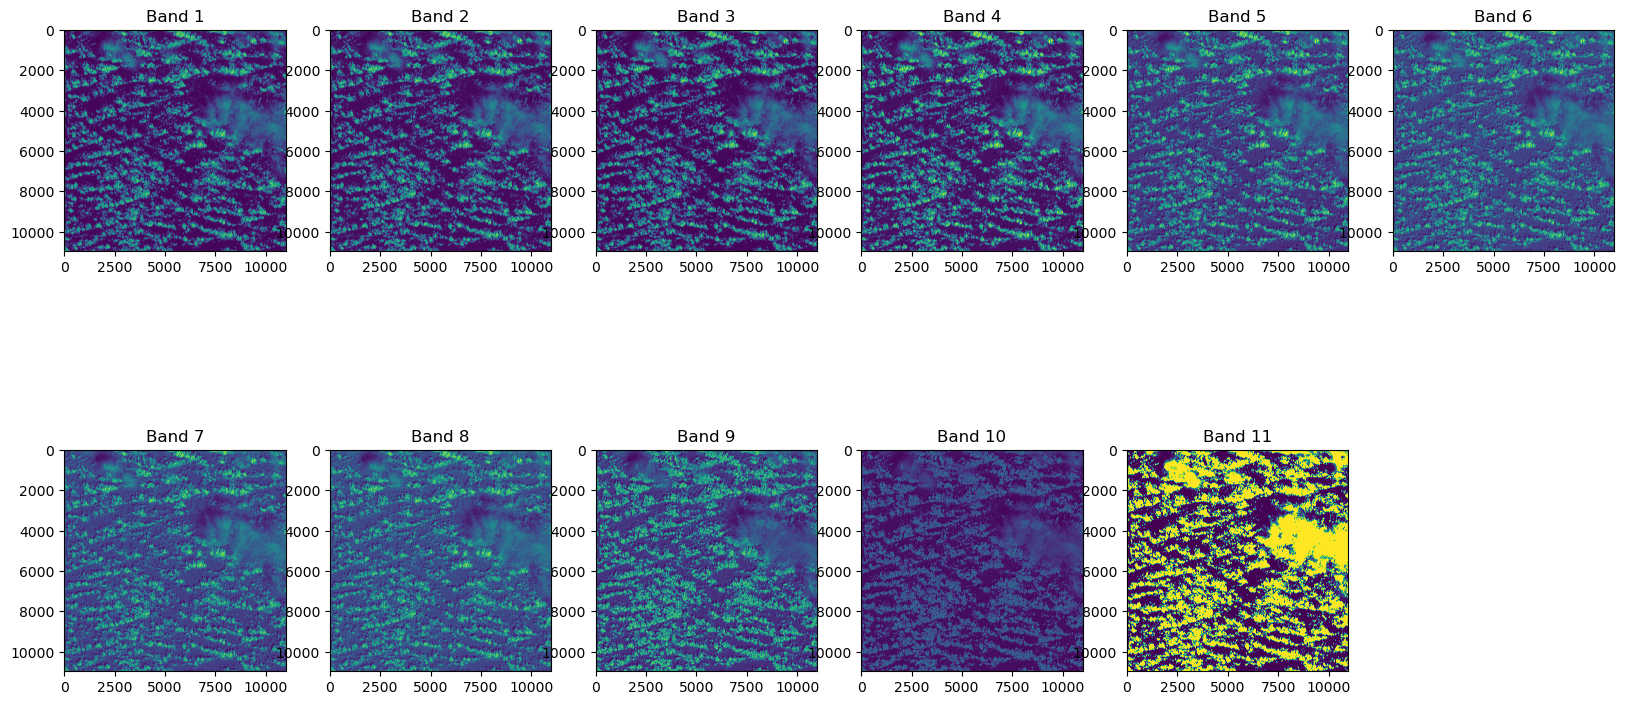

In [8]:
show_images(img,cols=6)

### Let's first visualize just RGB  and the corresponding mask

Text(0.5, 1.0, 'Cloud Mask')

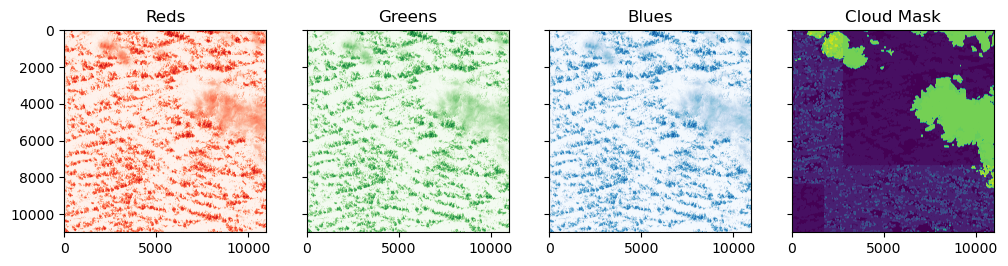

In [9]:

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize = (12,12))
img1 = ax1.imshow(img_rgb[0], cmap = 'Reds')
ax1.axis('on') 
ax1.set_title("Reds")

img2 = ax2.imshow(img_rgb[1], cmap = 'Greens')
ax2.axis('on')    
ax2.set_title("Greens")

img3 = ax3.imshow(img_rgb[2], cmap = 'Blues')
ax3.axis('on')
ax3.set_title("Blues")

msk = ax4.imshow(np.transpose(mask, (1,2,0)))
ax4.set_title("Cloud Mask")

## Segmentation part

In [10]:
# From now and to make it easier, only RGB images are used

In [11]:
# Set the paths
PATH_train = 'images_RGB/train/'
PATH_mask_train = 'mask/train/'

In [12]:
PATH_test = 'images_RGB/test/'
PATH_mask_test = 'mask/test/'

### 1. Cut large images into small patches


In [13]:
# For that, I use patchify. Let's have a look to one example.
# For this example, I will use a "big" patch size, only for visualization purposes. 
# Note that for the training, a smaller patch size (256) is used.

In [14]:
N = img_rgb.shape[0] # number of channels
patch_size = 2816 #
patches_img = patchify(img_rgb, (N, patch_size, patch_size), step=patch_size)  #Step=2816 for 2816 patches means no overlap           

In [15]:
print(patches_img.shape) 

(1, 3, 3, 3, 2816, 2816)


In [16]:
# drop extra dimension added by patchify
patches_img = patches_img[0]

In [17]:
patches_img.shape

(3, 3, 3, 2816, 2816)

Text(0.5, 1.0, 'large image')

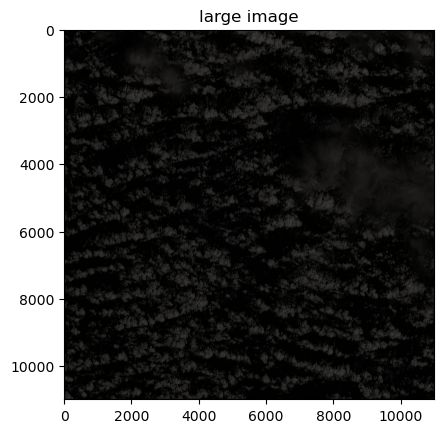

In [18]:
# let's see the patches
plt.imshow(np.transpose( np.array(img_rgb/255, np.int32), (1,2,0)))
plt.title('large image')

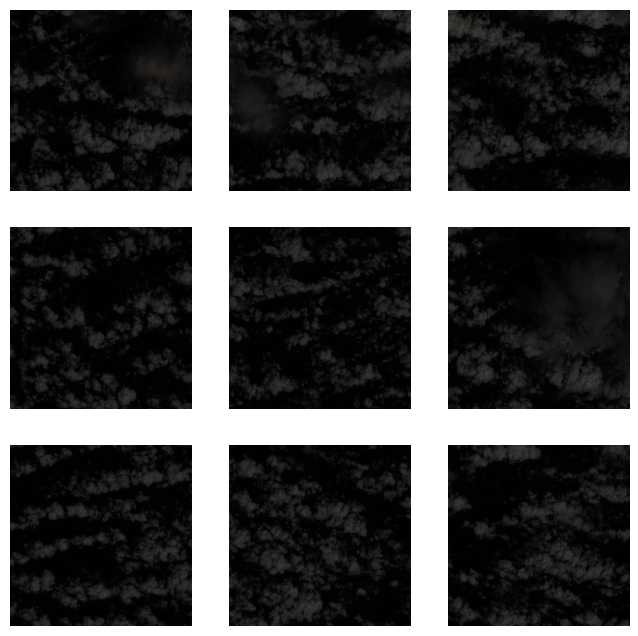

In [19]:
# let's see the patches
fig = plt.figure(figsize=(8, 8))
rows= 3
columns=3
k=1
for i in range(0,3):
    for j in range(0,3):
        i_img = patches_img[i,j,:,:,:]
        i_img = np.transpose(np.array(i_img/255, np.int32), (1,2,0))
        fig.add_subplot(rows, columns, k)
        plt.imshow(i_img)
        plt.axis('off')
        k = k +1
plt.show()


In [20]:
# define patch size 
patch_size = 256
bands=[1,2,3]
all_small_patches = prepare_patches(PATH_train, patch_size, bands, PATH_OUT=None, masks = False)

In [28]:
# Now process the masks
bands_masks=[1]

In [29]:
all_small_masks = prepare_patches(PATH_mask_train, patch_size, bands_masks, masks = True)

In [30]:
print(all_small_patches.shape)
print(all_small_masks.shape)
print("Pixel values in the mask are: ", np.unique(all_small_masks))
print("Pixel values in the mask are: ", len(np.unique(all_small_masks)))

(19404, 3, 256, 256)
(19404, 1, 256, 256)
Pixel values in the mask are:  [  0   1   3   7  11  15  16  17  19  23  27  31  33  35  39  43  47  49
  51  55  59  63  97 107 131 135 139 143 147 151 155 159 163 167 171 175
 179 183 187 191]
Pixel values in the mask are:  40


In [61]:
def vis_patch(image, mask):
    
    img = np.clip(image, 0, 2000)/2000.0
    
    f, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    ax[0].imshow(np.transpose(img, (1,2,0)))
   
    mask = np.clip(mask, 0, 50)/50.0 # we put max to 50 here but this is image specific
    ax[1].imshow(np.transpose(np.repeat(mask, [3], axis=0),(1,2,0))) #simple hack to show 1 channel as 3, we just copy it 3 times :)

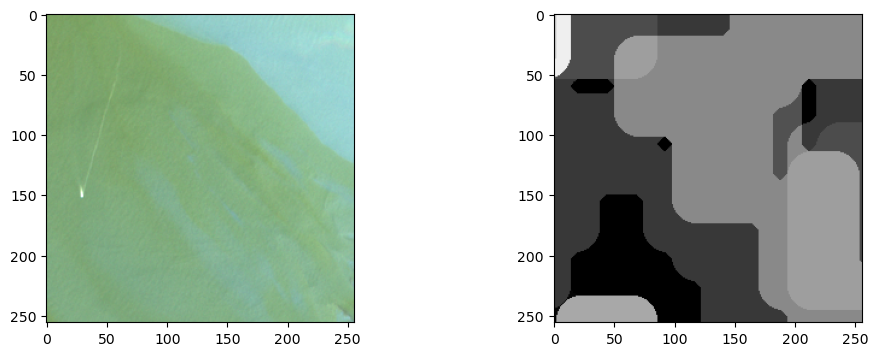

In [65]:
vis_patch(all_small_patches[100,:,:,:], all_small_masks[1,:,:,:])

In [66]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(4, 4))

        ax[0].imshow(image[0,:,:])
        ax[1].imshow(mask[0,:,:])
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image[0,:,:])
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask[0,:,:])
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image[0,:,:])
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask[0,:,:])
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

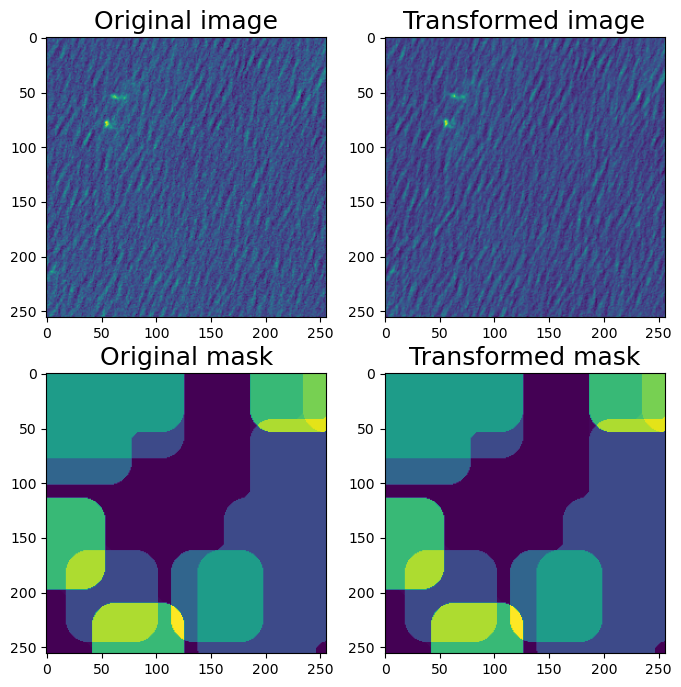

In [67]:
import albumentations as A

aug = A.Compose([
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5)]
)

img = all_small_patches[0,:,:,:]
msk = all_small_masks[0,:,:,:]
augmented = aug(image=img, mask=msk)
image_light = augmented['image']
mask_light = augmented['mask']
visualize(image_light, mask_light, original_image=img, original_mask=msk)

In [68]:
# Let's start modelling

In [80]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [81]:
class CloudDataset(Dataset):
    def __init__(self, image, mask, transforms = None):
       
        self.image = image
        self.mask = mask
        self.transforms = transforms
       
    def __getitem__(self, idx):
        
        img = self.image[idx]
        mask = self.mask[idx]
        mask = np.where(mask>1, 1, 0).astype(mask.dtype)
        if self.transforms:
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        
        return img, mask

    def __len__(self):
        return len(self.image)

In [82]:
input_img = scaler.fit_transform(all_small_patches.reshape(-1, all_small_patches.shape[-1])).reshape(all_small_patches.shape)

In [84]:
data = CloudDataset(input_img, all_small_masks)

In [85]:
x, y = data[100]
x.shape, y.shape

((3, 256, 256), (1, 256, 256))

In [86]:
train_size = int(0.8 * len(all_small_patches))
valid_size = len(all_small_patches) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(data, [train_size, valid_size])

In [87]:
train_dl = DataLoader(train_dataset, batch_size=12)
valid_dl = DataLoader(valid_dataset, batch_size=12)

In [88]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 3, 256, 256]), torch.Size([12, 1, 256, 256]))

In [36]:
model = UNet(3,1)

In [47]:
epochs=5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params = model.parameters(), lr=0.01)

In [48]:
import torch
import time
from tqdm import tqdm

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs):
   
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    
    model.to(device)

    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    best_acc = 0.0

    dataloader = train_dl
    val_loader = valid_dl
    
    print('Training')
    print('=' * 60)
    model.train()
    #start = time.time()

    for epoch in range(1,epochs+1):
        loss_temp = 0.0
        acc_temp = 0.0
        time.sleep(0.2)
        with tqdm(dataloader,unit='batch') as pbar:
            # iterate over data
            pbar.set_description('Epoch: {}/{}'.format(epoch,epochs))
            for data in pbar:
                x,y = data
                # forward pass
                outputs = model(x)

                # compute loss
                #loss = loss_fn(outputs, y.long())
                loss = loss_fn(outputs, y.type(torch.FloatTensor))

                # zero the gradients
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #compute the accuracy
                acc = acc_fn(outputs, y)

                acc_temp  += acc
                loss_temp += loss 

                pbar.set_postfix(loss=loss.item(), accuracy=100. * acc.item())
   
              
            running_loss = loss_temp / len(dataloader)
            running_acc = acc_temp / len(dataloader)
            pbar.set_postfix(loss=running_loss, accuracy=100. *running_acc)
            #print('Epoch {} Loss: {:.4f} Acc: {}'.format(epoch, running_loss, running_acc))

            print('Validation')
            print('=' * 60)

            val_loss = 0
            val_acc = 0

            for val_data in val_loader:
                x_val = val_data['image'].to(device)
                y_val = val_data['label'].to(device)
                y_val = torch.squeeze(y_val,1)

                # forward pass
                val_outputs = model(x_val)
                with torch.no_grad():
                    # compute loss
                    val_loss_temp = loss_fn(val_outputs, y_val.long())
                    val_acc_temp = acc_fn(val_outputs, y_val)

                    val_loss += val_loss_temp
                    val_acc += val_acc_temp

            running_val_loss = val_loss/len(val_loader)
            running_val_acc = val_acc/len(val_loader)

            print('Validation Loss: {}  Validation Acc: {}'.format(running_val_loss, running_val_acc))
            train_loss.append(running_loss) 
            train_acc.append(running_acc)

            valid_loss.append(running_val_loss)
            valid_acc.append(running_val_acc)
 
    train_loss_ = [train_loss[i].cpu().detach().numpy() for i in range(len(train_loss))]
    valid_loss_ = [valid_loss[i].cpu().detach().numpy() for i in range(len(valid_loss))]
    train_acc_ = [train_acc[i].cpu().detach().numpy() for i in range(len(train_acc))]
    valid_acc_ = [valid_acc[i].cpu().detach().numpy() for i in range(len(valid_acc))]
    
    return train_loss_, valid_loss_, train_acc_, valid_acc_    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb).float().mean()

In [50]:
train_loss, valid_loss, train_acc, valid_acc = train(model, train_dl, valid_dl, loss_fn, optimizer, acc_metric, epochs = 2)

Training


Epoch: 1/2:   3%|▎         | 35/1176 [09:31<5:10:27, 16.33s/batch, accuracy=49.8, loss=-]


KeyboardInterrupt: 

In [75]:
test_dataloader = valid_dl
test_data, mask_data = next(iter(test_dataloader))
    
model.to('cpu')
y_hat = model(test_data)

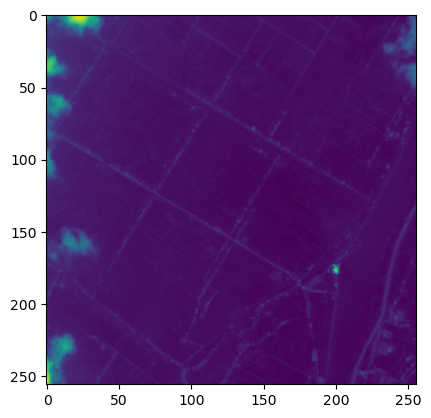

In [101]:
data = test_data[0]
plt.imshow(data[0,:,:])

In [115]:
def plot_img(test_dataloader,model,n):
    
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    
    test_data = next(iter(test_dataloader))
    test_data, mask_data = next(iter(test_dataloader))
    
    model.to(device)
    y_hat = model(test_data)
    
    if n>len(test_dataloader):
        n = len(test_dataloader)
        
    for j in range(n):
        plt.figure(figsize = (10, 8))
        plt.subplot(j+1,3,1)
        data = test_data[j]
        data = np.clip(data, 0, 1)
        plt.imshow(np.transpose(data.detach().numpy().astype('uint8'), (1,2,0)))
        plt.title('Pre-processed Original Image')
        plt.axis('off')

        plt.subplot(j+1,3,2)
        mask = mask_data[j]
        plt.imshow(np.transpose(mask, (1,2,0)))
        plt.title('Original Mask')
        plt.axis('off')

        plt.subplot(j+1,3,3)
        pred = y_hat.argmax(0)
        plt.imshow(np.transpose(pred, (1,2,0)))
        plt.title('Predicted Mask')
        plt.axis('off')

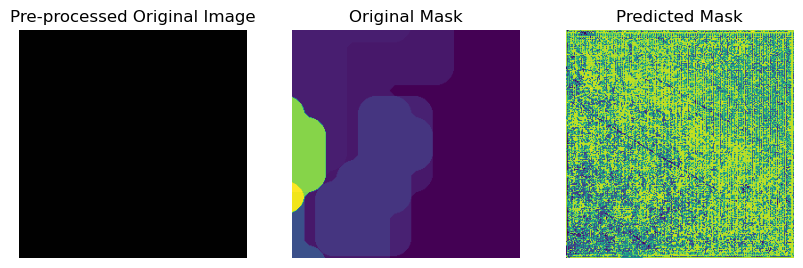

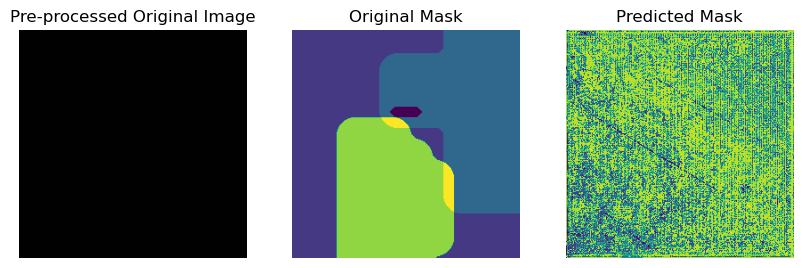

In [116]:
plot_img(valid_dl, model, n=2)